In [86]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix,eye,bmat
from scipy.sparse.linalg import eigs,inv,gmres
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
%matplotlib inline

In [14]:
data = pd.read_csv('data/round_train.csv')

In [3]:
data = data[data.Tournament_Year.isin([2003,2004])]

In [15]:
data.shape

(201347, 12)

In [16]:
data.head()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
0,2003,10,16,656,1320,"Estes, Bob",1,11:50,66,T6,7.5,0.197917
1,2003,10,16,656,1361,"Forsman, Dan",1,11:00,69,T21,22.0,0.600694
2,2003,10,16,656,1761,"Mattiace, Len",1,13:00,75,24,24.0,0.656250
3,2003,10,16,656,1797,"Mediate, Rocco",1,12:10,72,T2,2.5,0.059028
4,2003,10,16,656,1920,"Parry, Craig",1,11:20,71,T25,26.5,0.725694


In [17]:
inds = {num:ind for ind,num in enumerate(pd.unique(data.Player_Number))}

In [18]:
data.insert(5,'Player_Index',[inds[num] for num in data.Player_Number])

In [19]:
rounds = data.groupby(['Tournament_Year','Tournament_#','Round_Number'])

In [20]:
n_players = len(pd.unique(data.Player_Index))
n_rounds = len(rounds)

In [21]:
print n_players,n_rounds

2230 1968


In [78]:
def alpha(A,a):
    w,v = eigs(A,k=1,which='LM')
    return a/w[0].real

In [23]:
n_players*(n_rounds/16+1)

276520

In [67]:
def save_sparse_csc(filename,array):
    np.savez(filename,data=array.data ,indices=array.indices,
             indptr=array.indptr, shape=array.shape )

def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

def inflate(matrices,BETA):
    return bmat([[BETA**(abs(j-i)) * mat for i,mat in enumerate(matrices)] for j in range(len(matrices))])

In [68]:
A = csc_matrix(np.array([[0,1.2],[.8,0]]))
B = csc_matrix(np.array([[0,1.1],[.9,0]]))
print type((inflate([A,B],.9)!=0).astype(int))

<class 'scipy.sparse.csr.csr_matrix'>


In [61]:
# done

# bin_size = 16
# n_round_groups = int(math.ceil(n_rounds/float(bin_size)))
# print n_round_groups
# current_group = 0
# A = np.zeros((n_players,n_players))
# for round_ind,df in enumerate(rounds):
#     df = df[1]
#     round_group = round_ind/bin_size
#     if round_group>current_group:
#         A = csc_matrix(A)
#         save_sparse_csc('bin_size-%d/%d' % (bin_size,current_group),A)
#         print current_group
#         current_group = round_group
#         A = np.zeros((n_players,n_players))
#     arr = np.zeros((n_players,n_players))
#     arr[np.ix_(pd.unique(df.Player_Index),pd.unique(df.Player_Index))] = np.outer(1/df.Round_Score.values.astype(float),df.Round_Score.values)
#     np.fill_diagonal(arr,0)
#     A += arr

In [137]:
def run(a,b,bin_size):
    ranks = []
    w_as,w_gs = np.empty(0),np.empty(0)
    BETA = b
    n_round_groups = int(math.ceil(n_rounds/float(bin_size)))
    print n_round_groups
    current_group = 0
    tournaments=[set()]
    for round_ind,df in enumerate(rounds):
        df = df[1]
        round_group = round_ind/bin_size
        if round_group>current_group:
            A = inflate([load_sparse_csc('bin_size-%d/%d.npz' % (bin_size,i)) for i in range(current_group+1)],BETA)
            G = (A!=0).astype(float)
            print G.shape
            if current_group==0:
                S = eye(n_players*round_group,format='csc') - alpha(A,a)*A
                S_inv = inv(S)
                w_a = S_inv.dot(A.sum(1))
                S = eye(n_players*round_group,format='csc') - alpha(G,a)*G
                S_inv = inv(S)
                w_g = S_inv.dot(G.sum(1))
                w_as = np.append(w_as,w_a)
                w_gs = np.append(w_gs,w_g)
                ranks.append(np.squeeze(np.asarray(w_a/w_g)))
                print 'Round Group %d done' % current_group
                current_group = round_group
                tournaments.append(set())
            else:
                S = eye(n_players*round_group,format='csc') - alpha(A,a)*A
                k = A.sum(1)
                x_approx = np.append(w_as,w_as[-n_players:])
                w_a = gmres(S,k,x0=x_approx)[0]
                S = eye(n_players*round_group,format='csc') - alpha(G,a)*G
                k = G.sum(1)
                x_approx = np.append(w_gs,w_gs[-n_players:])
                w_g = gmres(S,k,x0=x_approx)[0]
                w_as = w_a
                w_gs = w_g
                ranks.append(np.squeeze(np.asarray(w_a/w_g))[-n_players:])
                print 'Round Group %d done' % current_group
                current_group = round_group
                tournaments.append(set())
        tournaments[current_group].update([df.iloc[0]['Permanent_Tournament_#']])
    for i in range(1,len(tournaments)):
        tournaments[i] = tournaments[i]-tournaments[i-1]
    ratings,outcomes = [],[]
    for t_ind in range(1,len(tournaments)):
        sub = data[data['Permanent_Tournament_#'].isin(tournaments[t_ind])]
        df1 = pd.DataFrame(sub.groupby('Player_Index')['Finishing_Pct'].mean())
        df2 = pd.DataFrame(ranks[t_ind-1],columns=['rating'])
        df = df1.merge(df2,left_index=True,right_index=True).dropna()
        ratings += df.rating.values.tolist()
        outcomes += df.Finishing_Pct.values.tolist()
    ratings,outcomes = np.array(ratings),np.array(outcomes)
    return np.corrcoef(ratings,outcomes)[0,1]

In [138]:
run(.9,.8,16)

123
(2230, 2230)
Round Group 0 done
(4460, 4460)
Round Group 1 done
(6690, 6690)
Round Group 2 done
(8920, 8920)
Round Group 3 done
(11150, 11150)
Round Group 4 done
(13380, 13380)
Round Group 5 done
(15610, 15610)
Round Group 6 done
(17840, 17840)
Round Group 7 done
(20070, 20070)
Round Group 8 done
(22300, 22300)
Round Group 9 done
(24530, 24530)
Round Group 10 done
(26760, 26760)
Round Group 11 done
(28990, 28990)
Round Group 12 done
(31220, 31220)
Round Group 13 done
(33450, 33450)
Round Group 14 done
(35680, 35680)
Round Group 15 done
(37910, 37910)
Round Group 16 done
(40140, 40140)
Round Group 17 done
(42370, 42370)
Round Group 18 done
(44600, 44600)
Round Group 19 done
(46830, 46830)
Round Group 20 done
(49060, 49060)
Round Group 21 done
(51290, 51290)
Round Group 22 done
(53520, 53520)
Round Group 23 done
(55750, 55750)
Round Group 24 done
(57980, 57980)
Round Group 25 done
(60210, 60210)
Round Group 26 done
(62440, 62440)
Round Group 27 done
(64670, 64670)
Round Group 28 done

KeyboardInterrupt: 

In [118]:
with open('example.txt','w') as f:
    for l in zip(csc_matrix(G[0:3,0:3]).data,zip(*[i.tolist() for i in csc_matrix(G[0:3,0:3]).nonzero()])):
        f.write(','.join(map(str,[l[0],l[1][0],l[1][1]])))
        f.write('\n')

In [66]:
def save_sparse_csc(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csc(filename):
    loader = np.load(filename)
    return csc_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

In [69]:
save_sparse_csc('example',csc_matrix(G))

In [53]:
for i in range(1,len(tournaments)):
    tournaments[i] = tournaments[i]-tournaments[i-1]

In [44]:
tournaments

NameError: name 'tournaments' is not defined

In [62]:
ols = LinearRegression()
iso = IsotonicRegression(increasing=False)

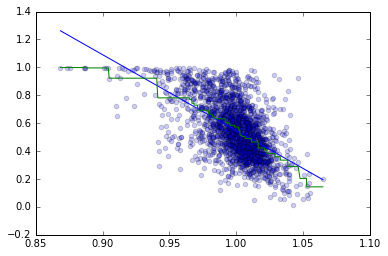

In [65]:
ratings,outcomes = [],[]
for t_ind in range(1,len(tournaments)):
    sub = data[data['Permanent_Tournament_#'].isin(tournaments[t_ind])]
    df1 = pd.DataFrame(sub.groupby('Player_Index')['Finishing_Pct'].mean())
    df2 = pd.DataFrame(ranks[t_ind-1],columns=['rating'])
    df = df1.merge(df2,left_index=True,right_index=True).dropna()
    ratings += df.rating.values.tolist()
    outcomes += df.Finishing_Pct.values.tolist()
ratings,outcomes = np.array(ratings),np.array(outcomes)
ols.fit(ratings[:,None],outcomes)
iso.fit(ratings,outcomes)
predictions_o = ols.predict(np.sort(ratings)[:,None])
predictions_i = iso.predict(np.sort(ratings))
plt.scatter(ratings,outcomes,alpha=.2)
plt.plot(np.sort(ratings),predictions_o)
plt.plot(np.sort(ratings),predictions_i)
plt.show()

In [50]:
print n_round_groups
print S.shape[0]**2

7
1768900


In [51]:
print len(S.nonzero()[1])/float(S.shape[0]**2)

0.15487704223


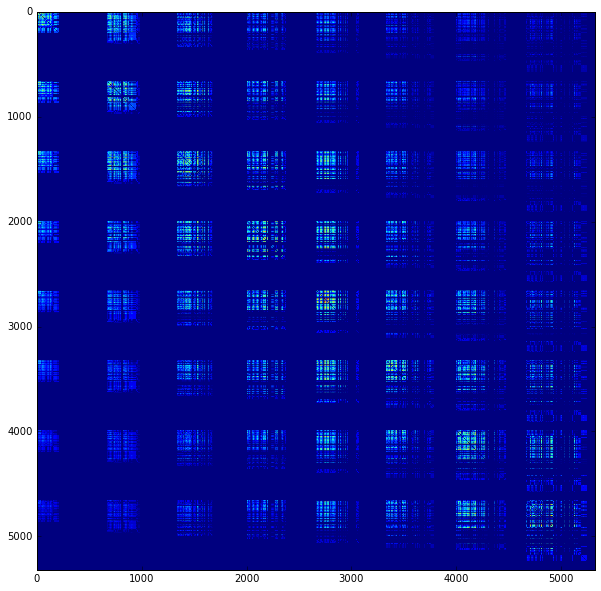

In [66]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(A_.toarray());

In [81]:
inds_to_name = {i:data[data.Player_Index==i].iloc[0].Player_Name for i in range(n_players)}

In [91]:
pd.DataFrame({'player_ind':range(n_players),
              'player_name':[inds_to_name[i] for i in range(n_players)],
              'rank':ranks[8]}).sort_values('rank',ascending=False)

,player_ind,player_name,rank
277,277,"Woods, Tiger",1.045181
13,13,"Singh, Vijay",1.044618
12,12,"Els, Ernie",1.040951
793,793,"Levin, Spencer",1.037054
27,27,"Goosen, Retief",1.033545
162,162,"Mickelson, Phil",1.031157
341,341,"Harrington, Padraig",1.030177
532,532,"Ruiz, Marco",1.030069
331,331,"Scott, Adam",1.028240
180,180,"Weir, Mike",1.027396


In [161]:
names_to_ind = {inds_to_name[key]:key for key in inds_to_name}

In [162]:
inds_to_plot = [names_to_ind['Woods, Tiger'],names_to_ind['Singh, Vijay']]

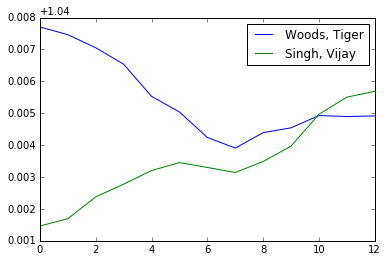

In [168]:
for j in inds_to_plot:
    plt.plot(ranks[[j + i*n_players for i in range(n_round_groups)]],label = inds_to_name[j]);
plt.legend();

# for i in [0,1]:
#     plt.plot(with_8[i])
#     plt.plot(with_9[i]);